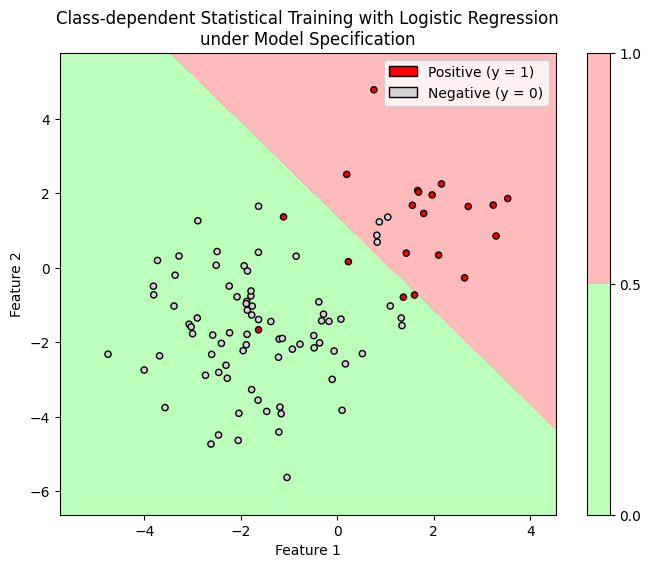

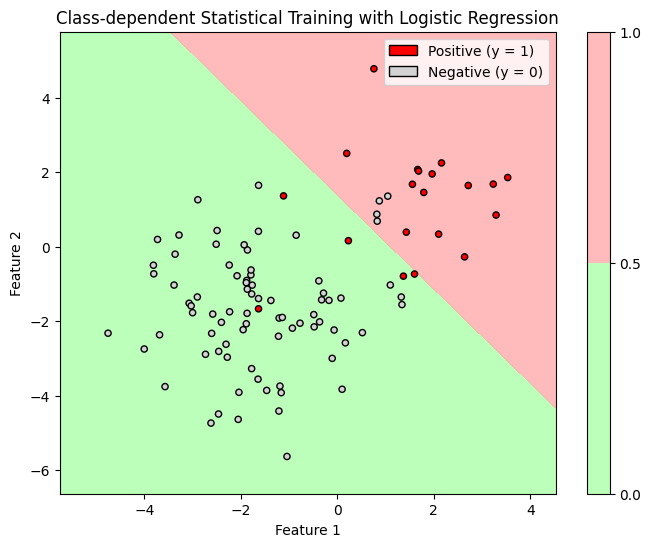

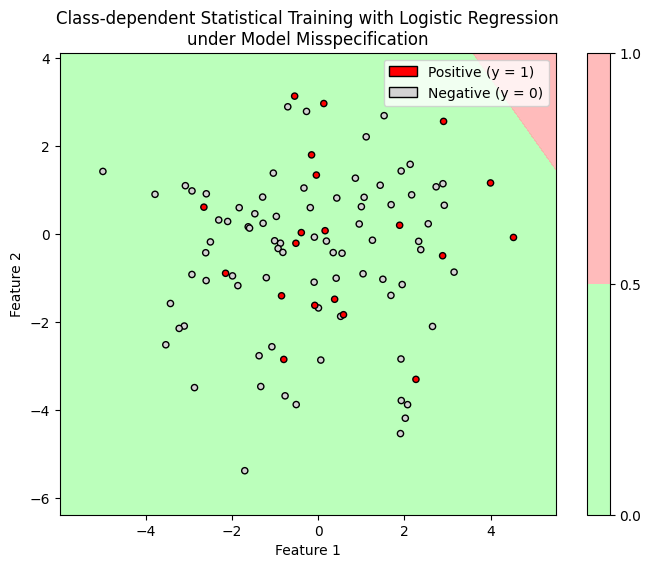

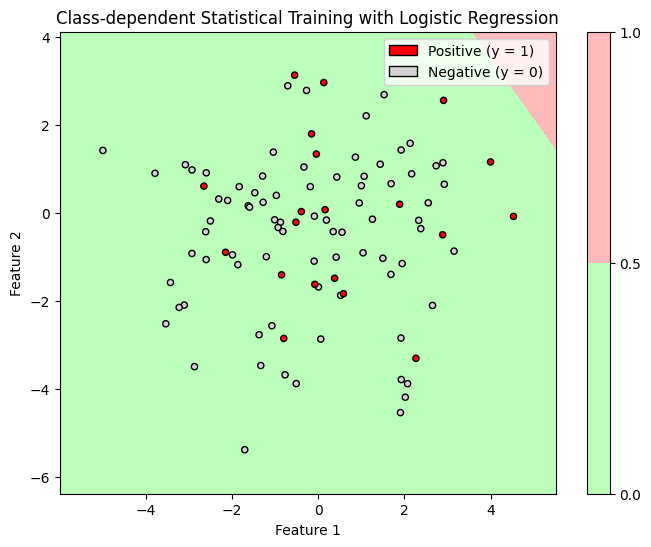

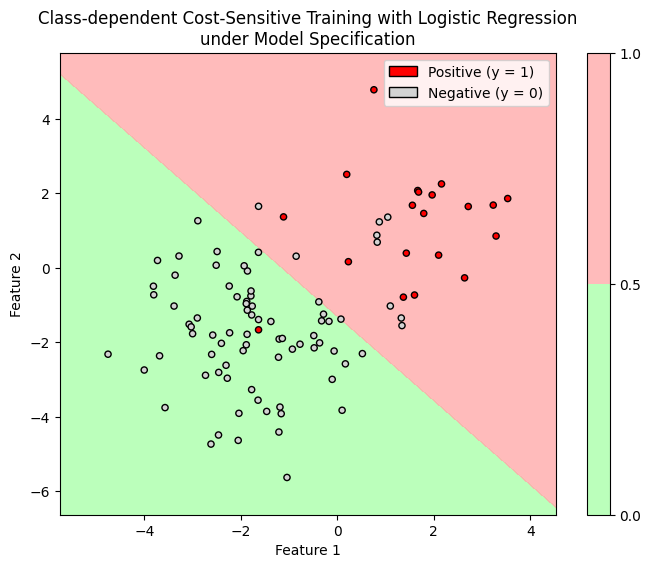

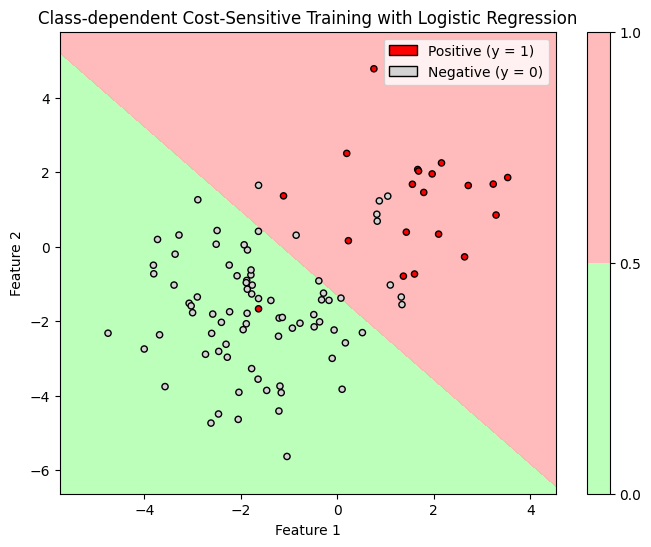

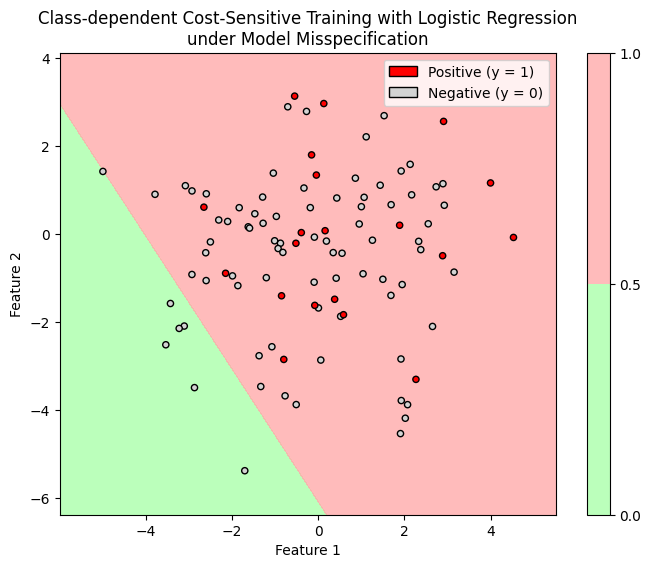

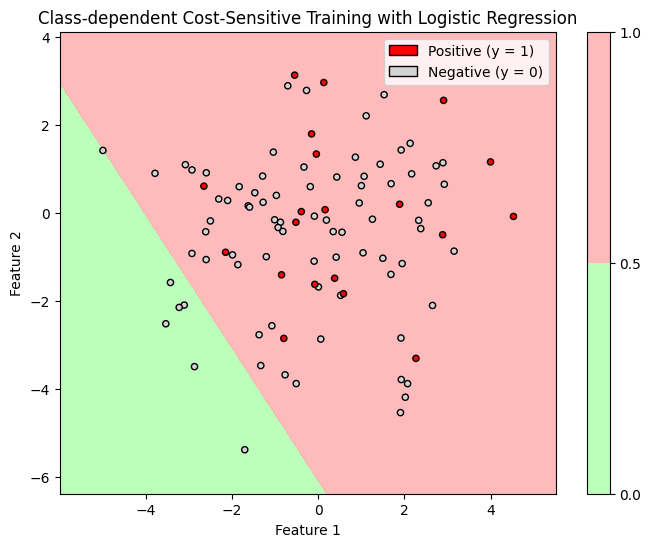

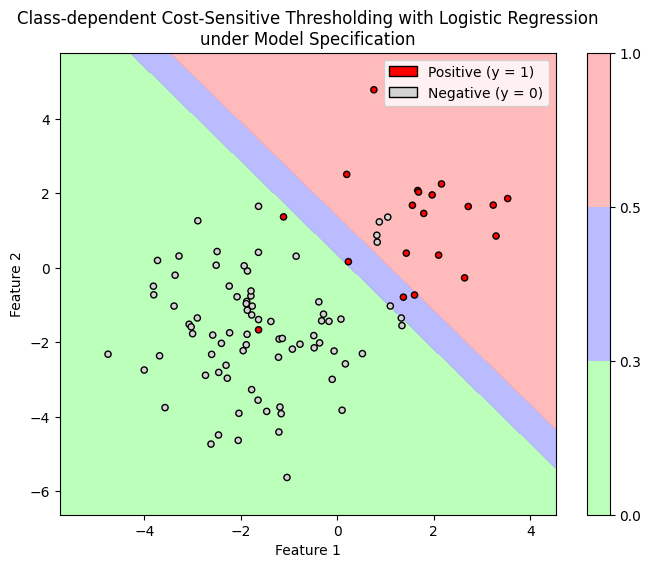

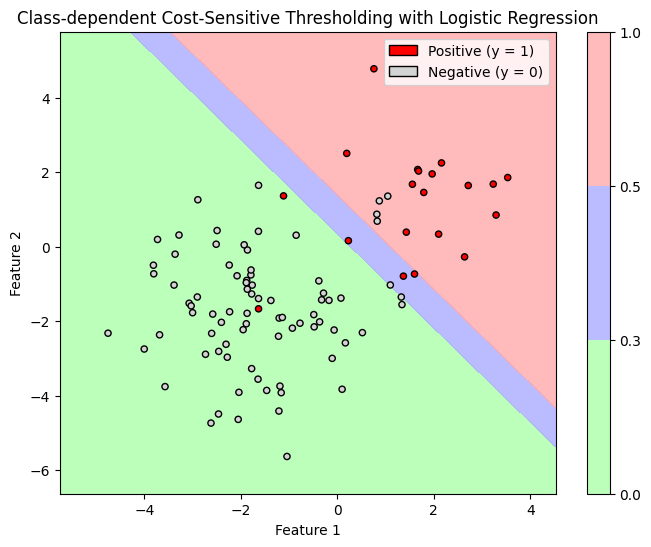

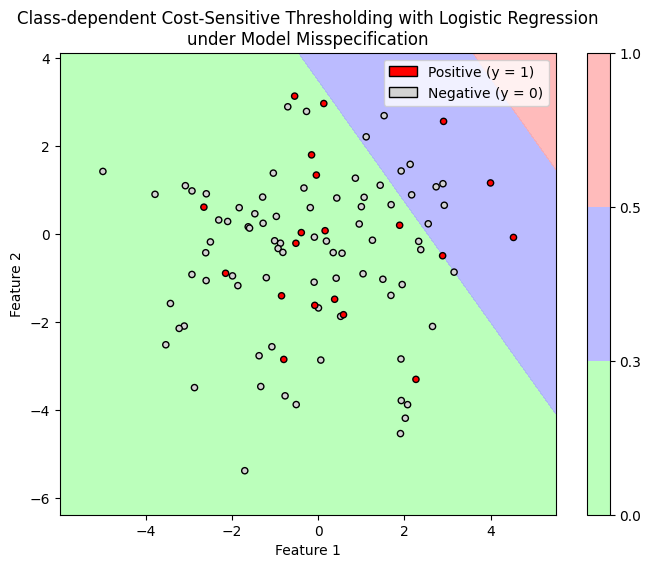

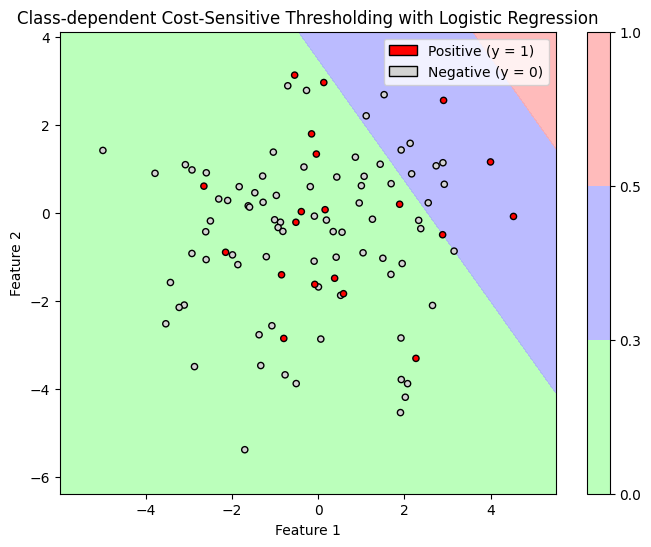

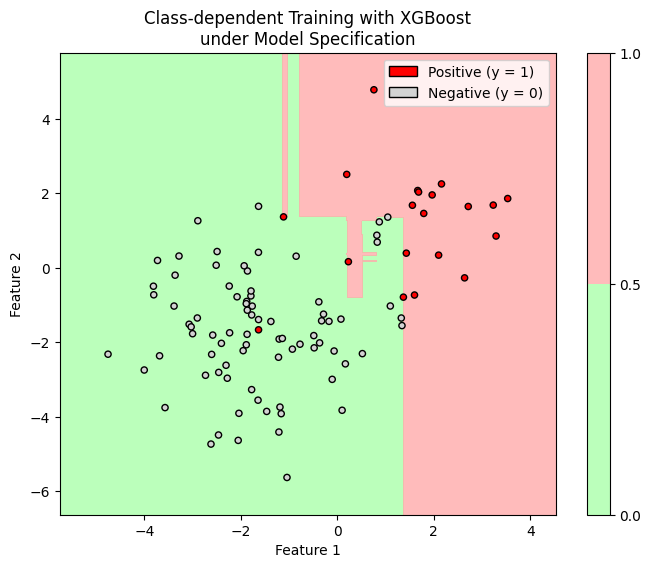

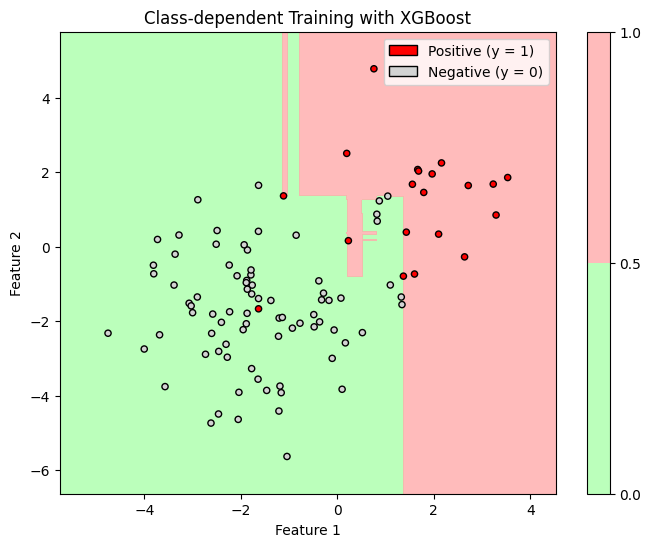

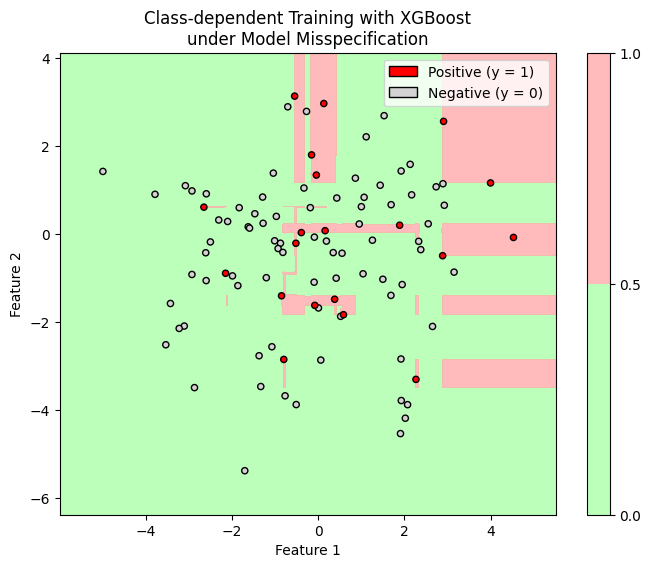

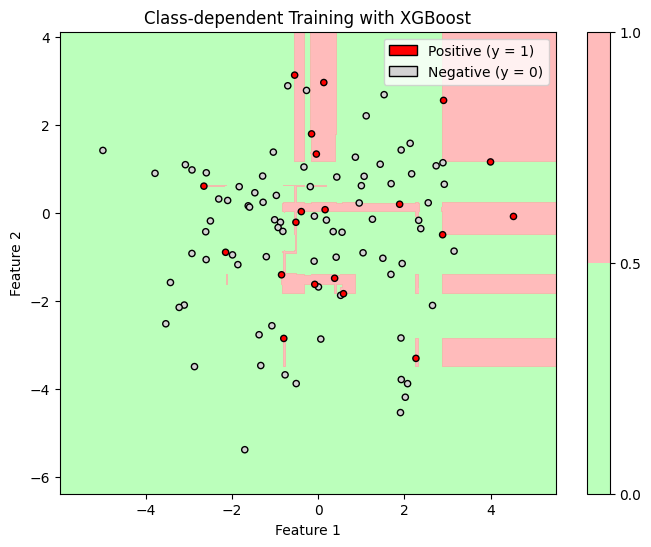

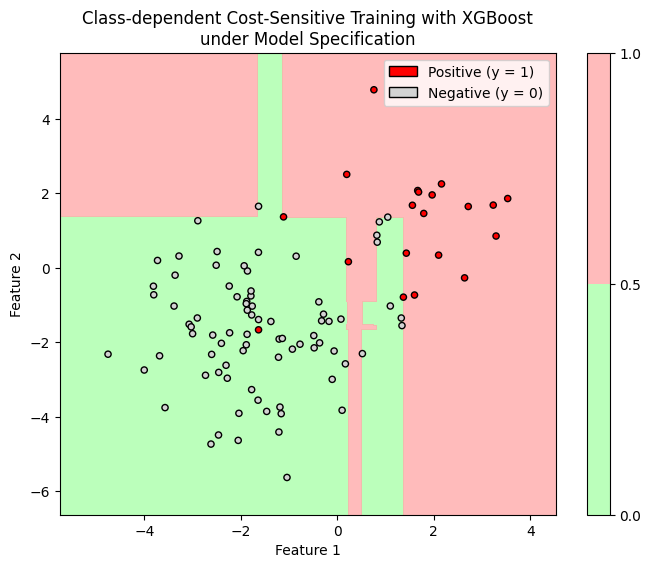

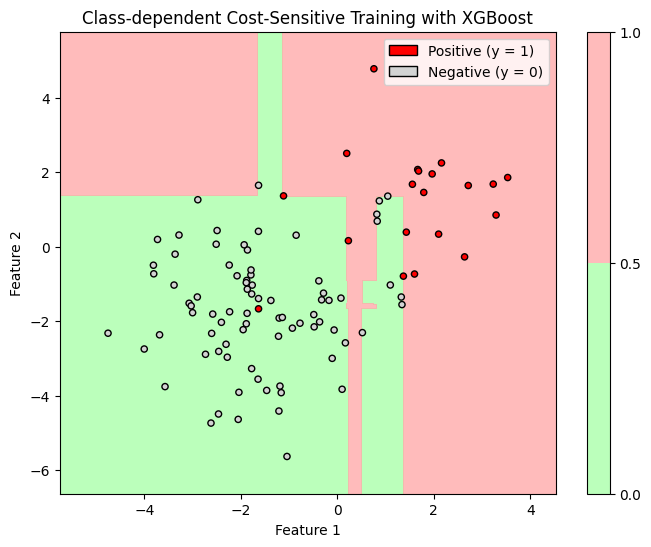

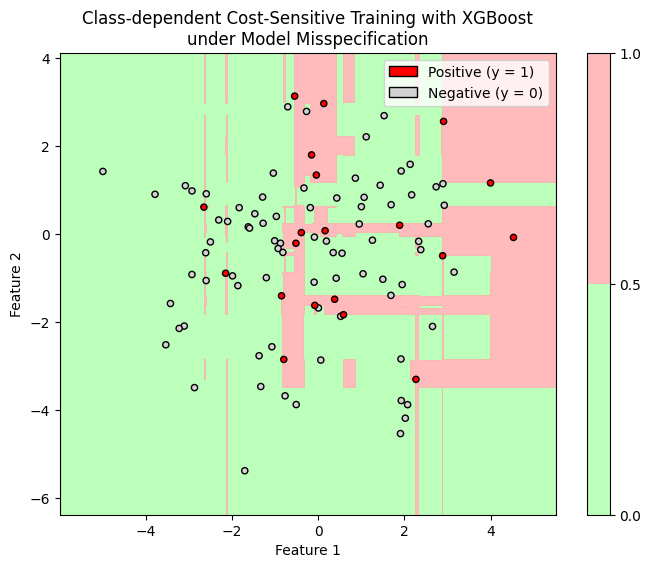

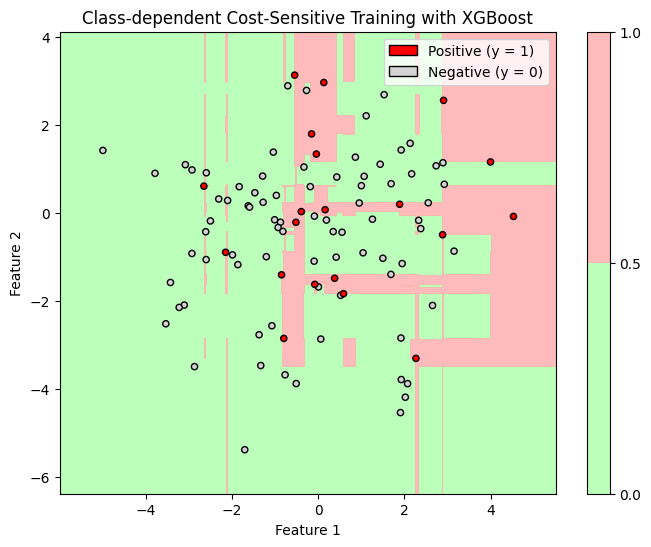

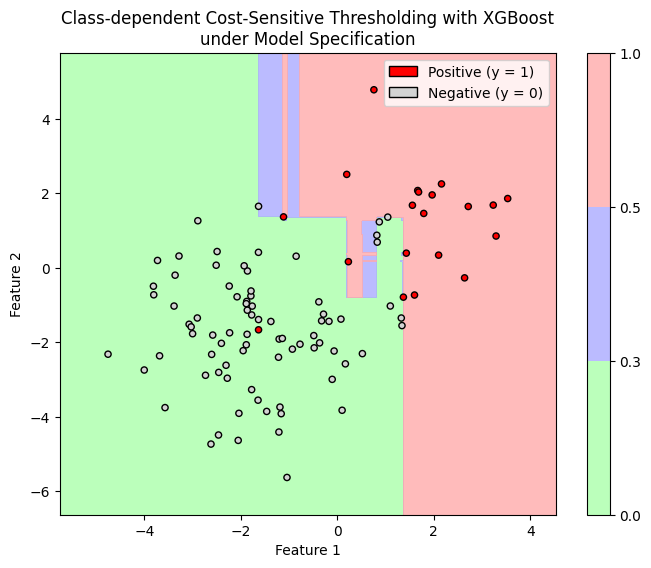

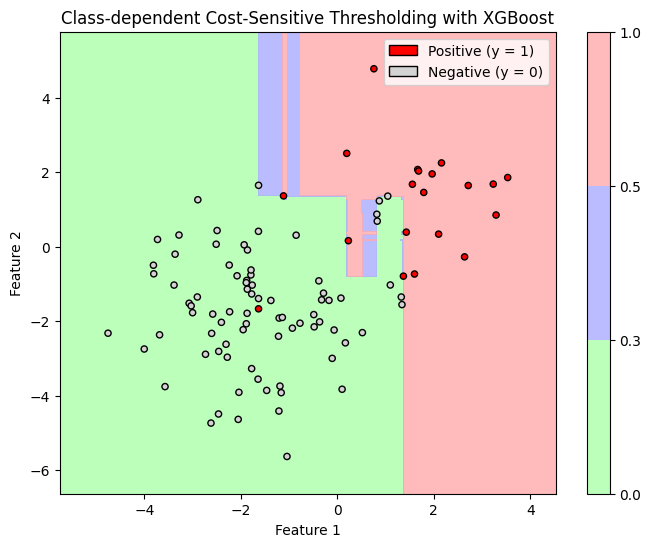

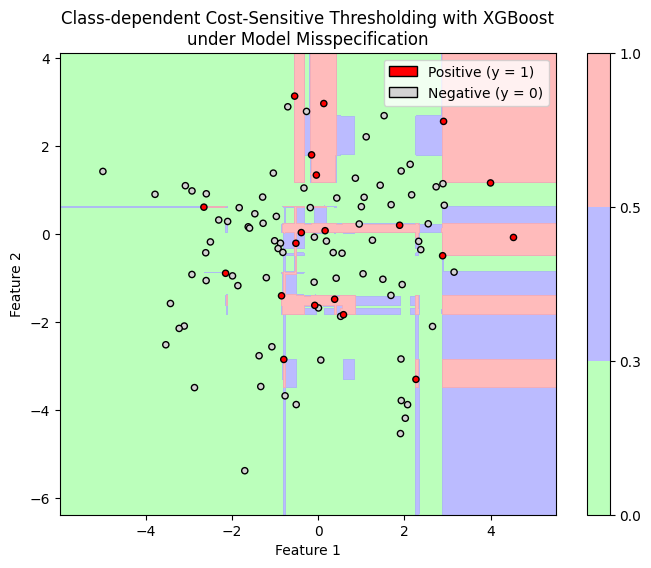

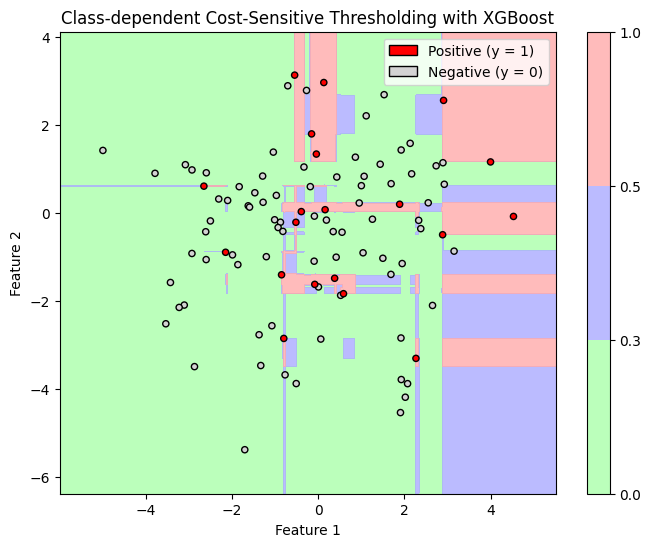

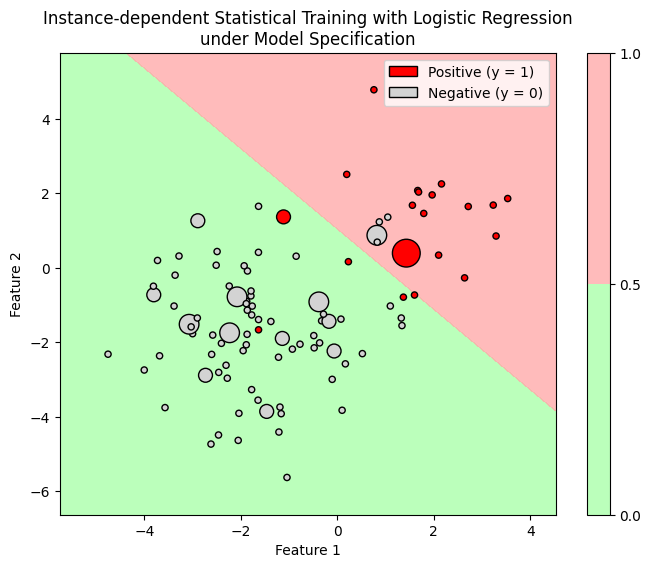

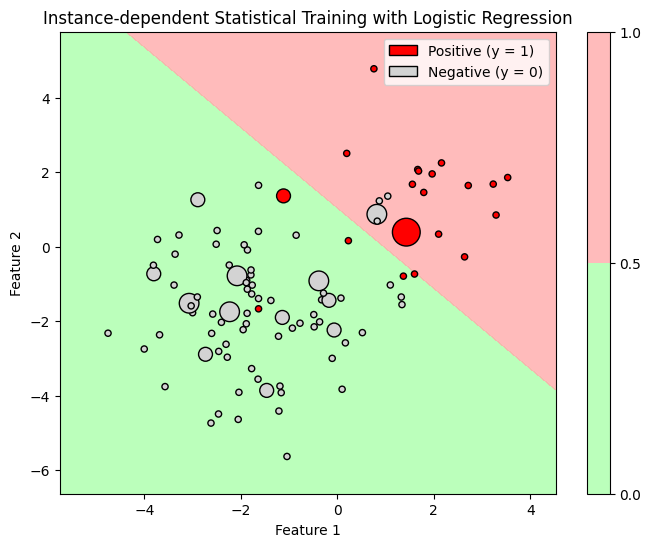

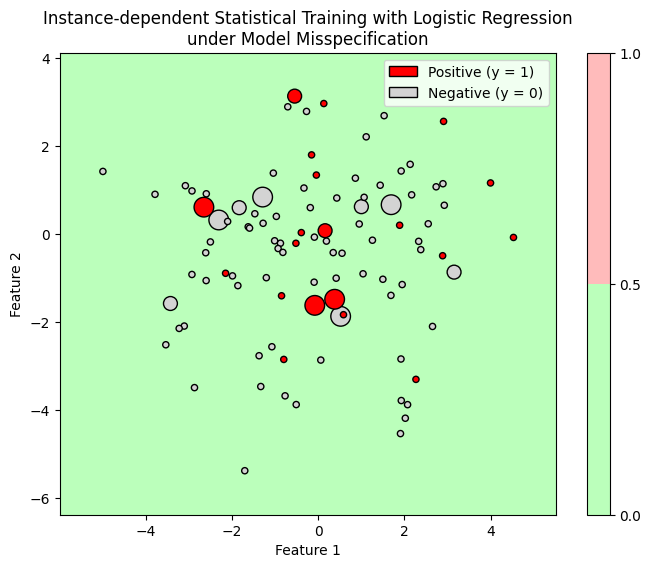

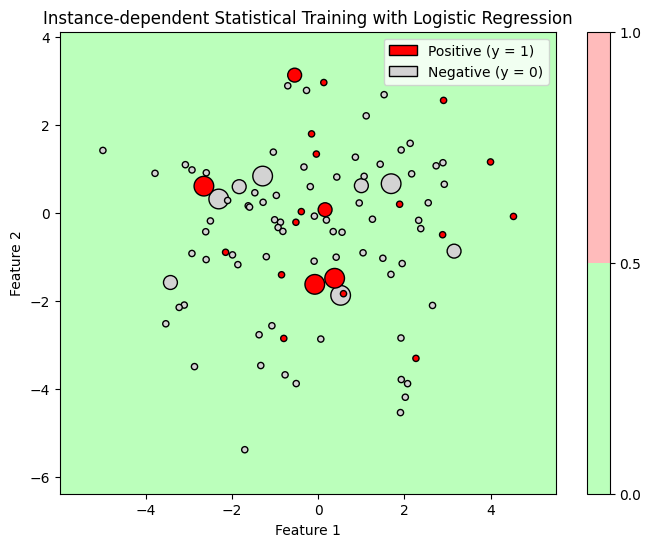

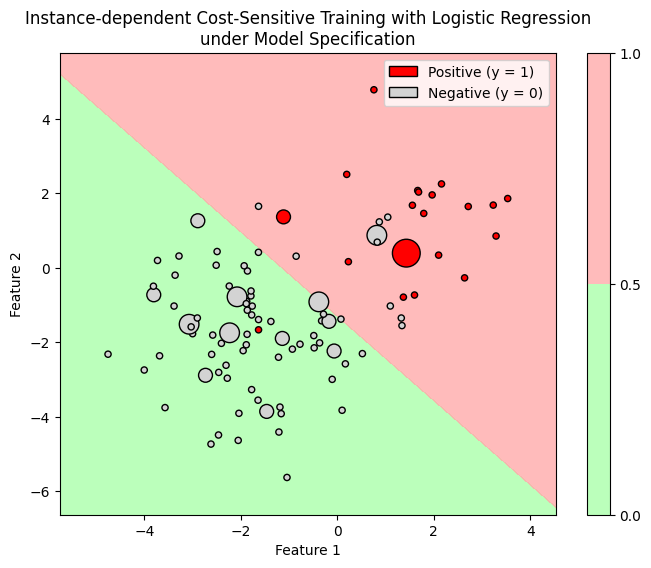

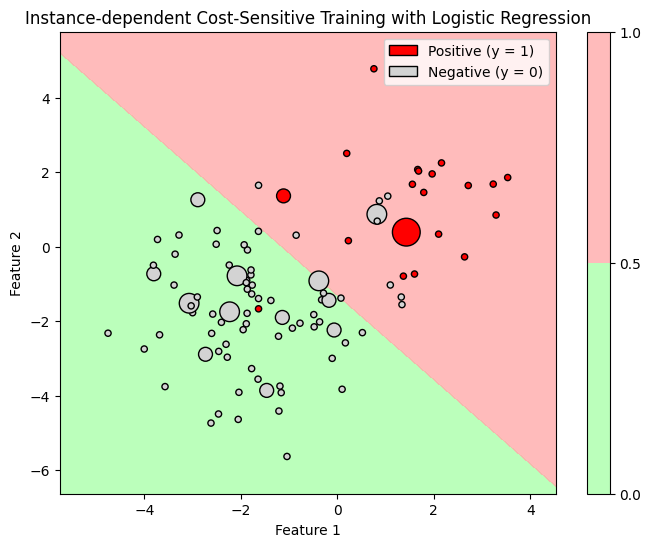

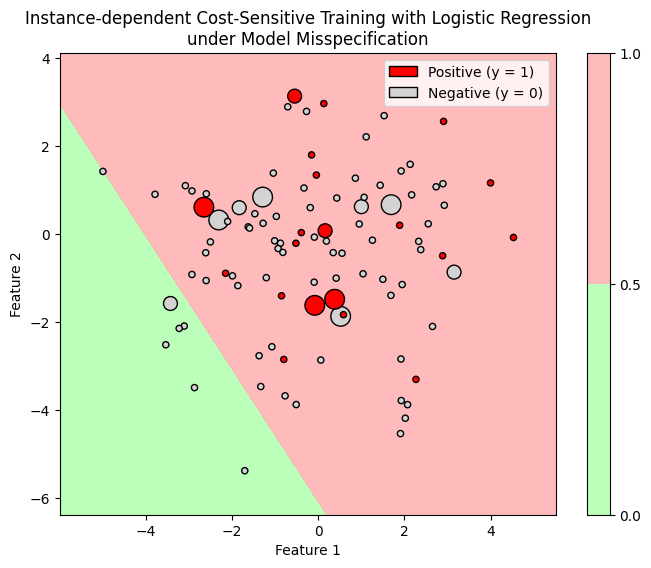

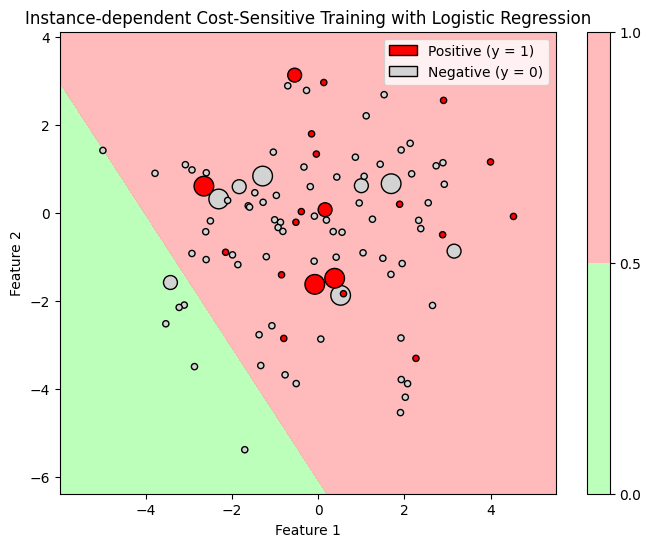

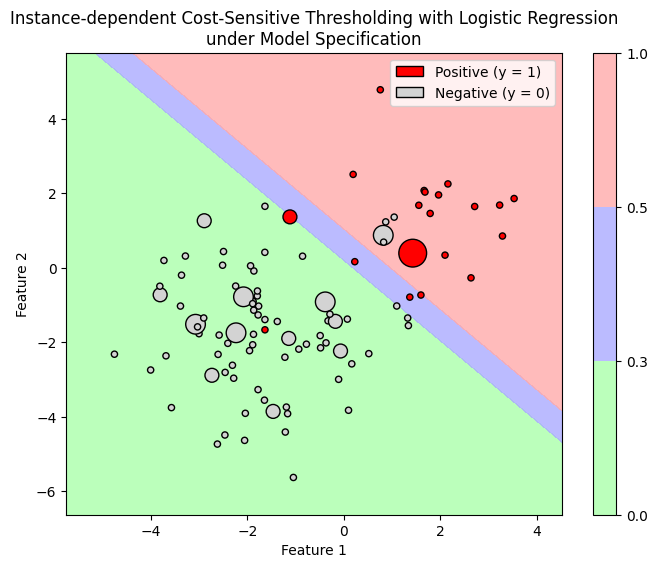

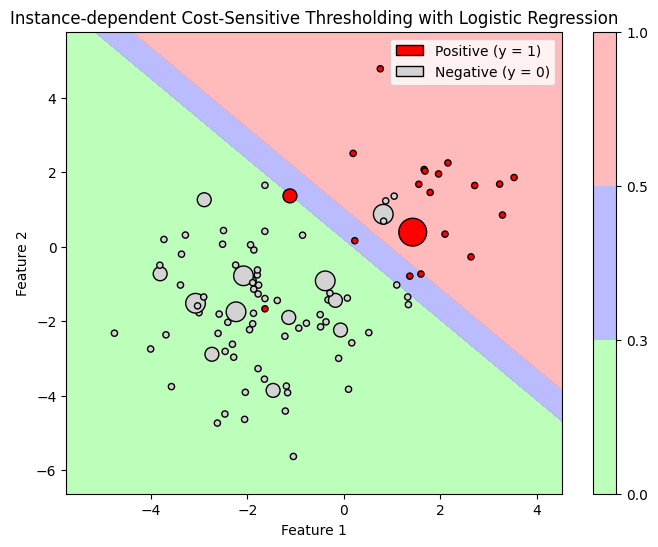

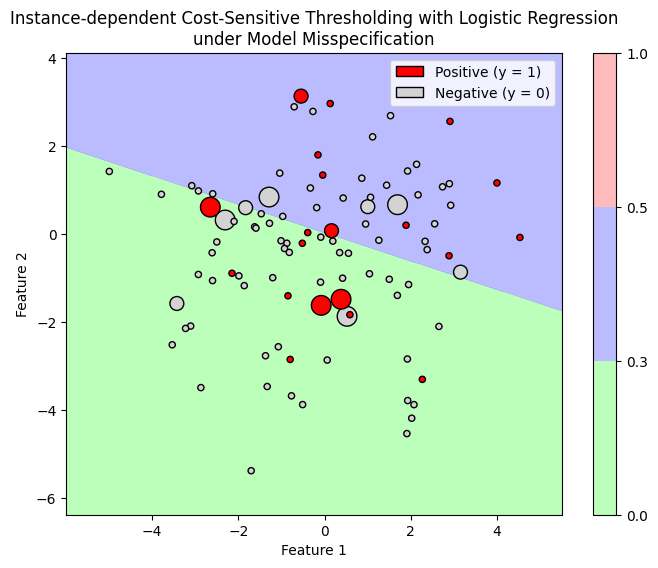

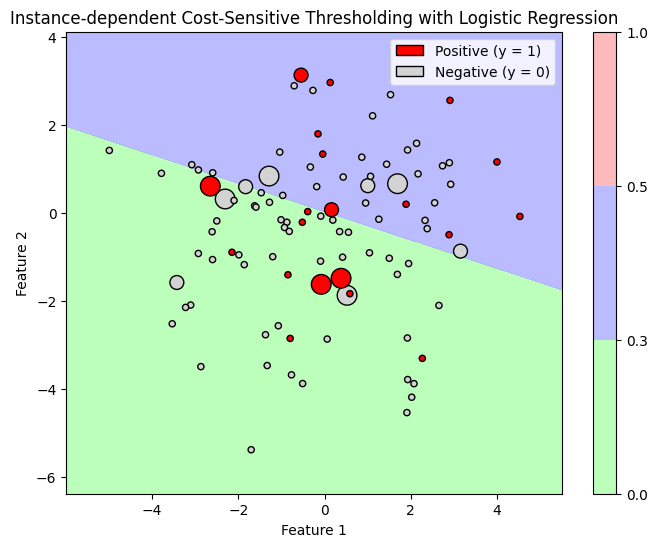

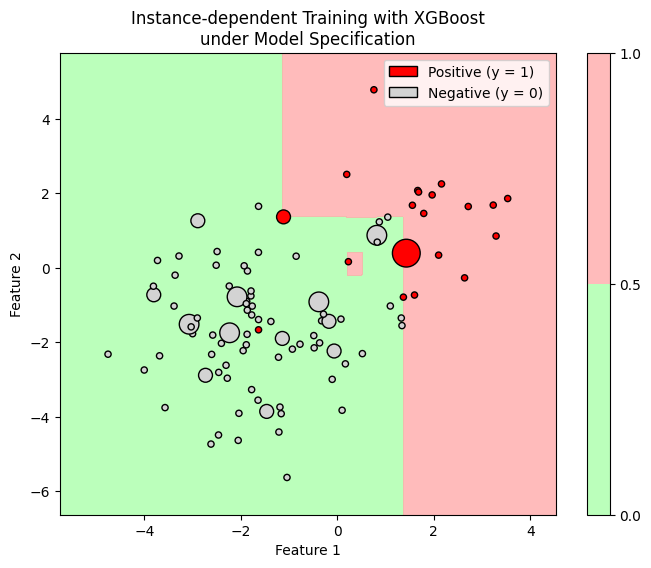

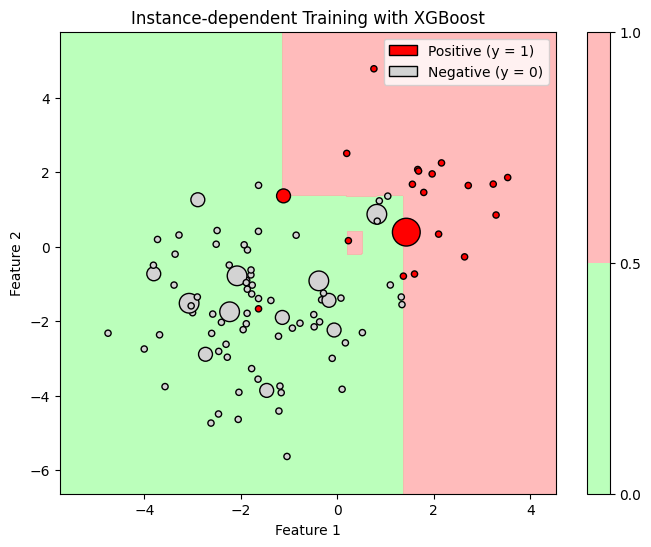

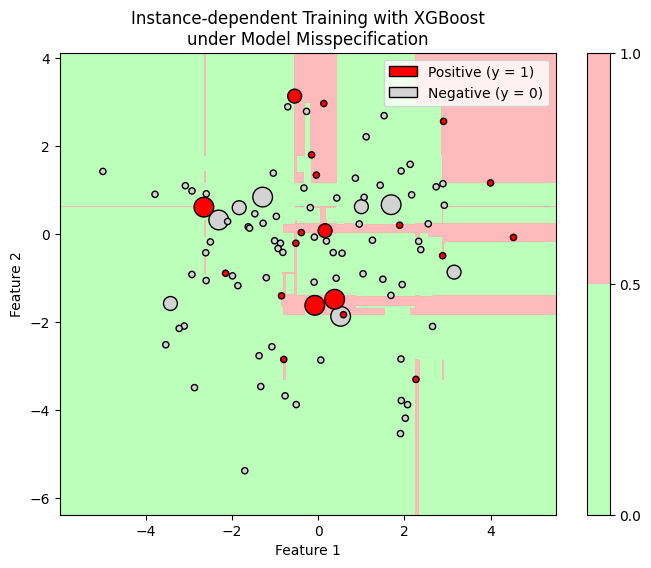

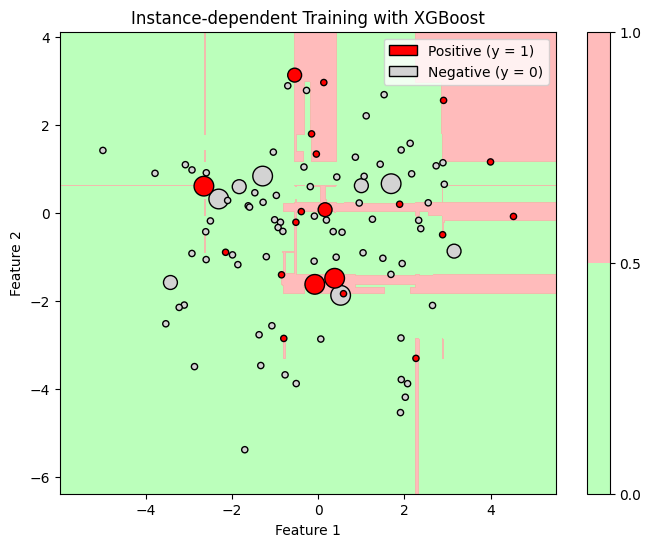

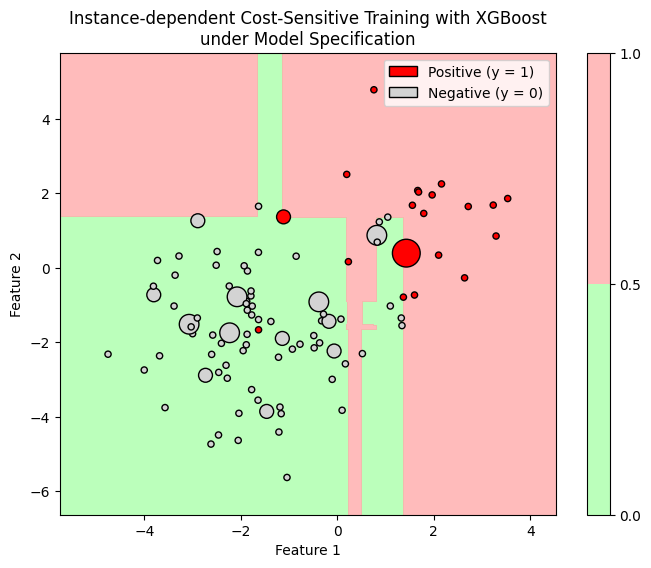

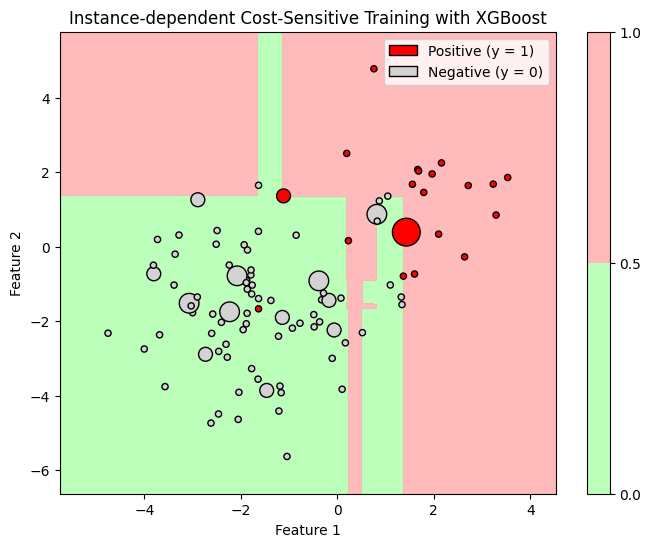

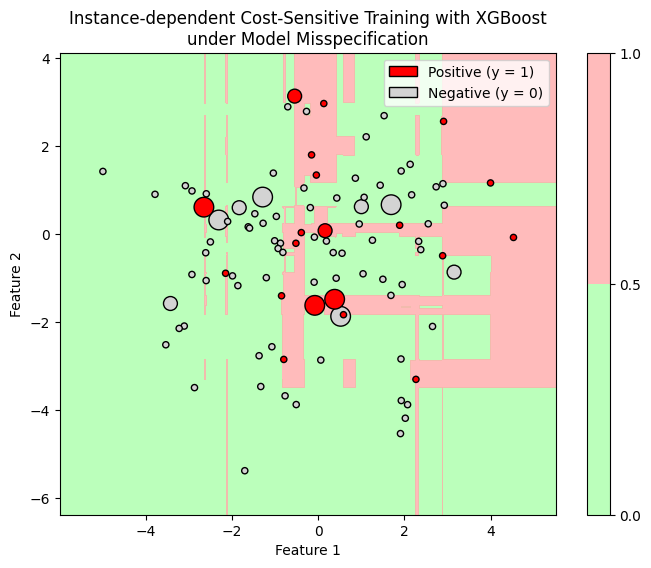

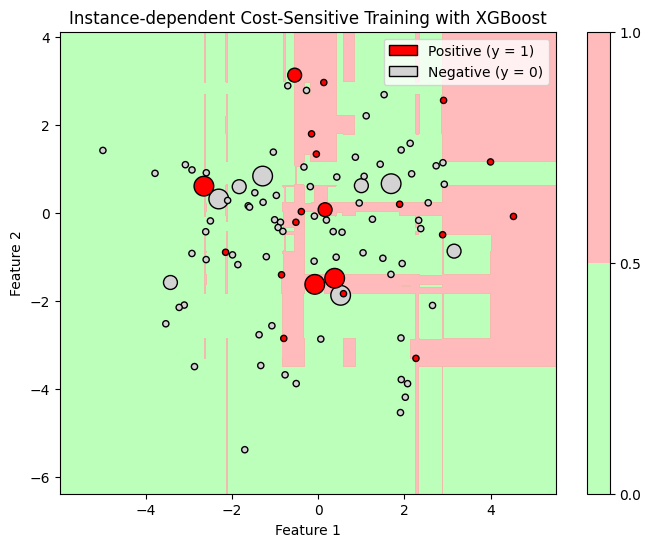

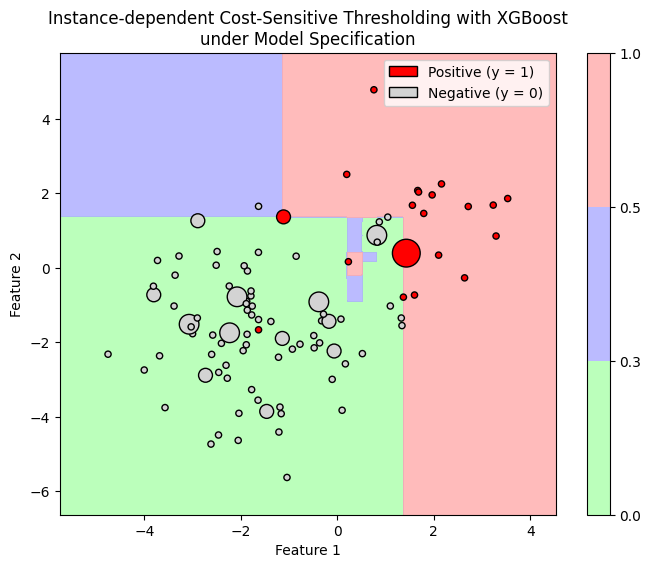

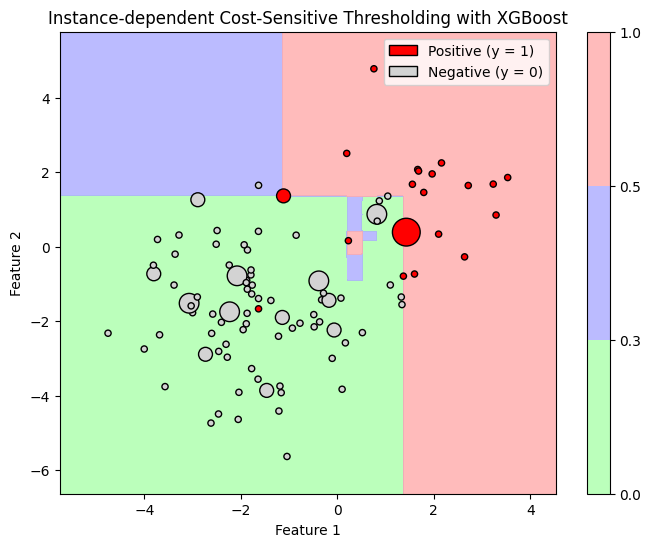

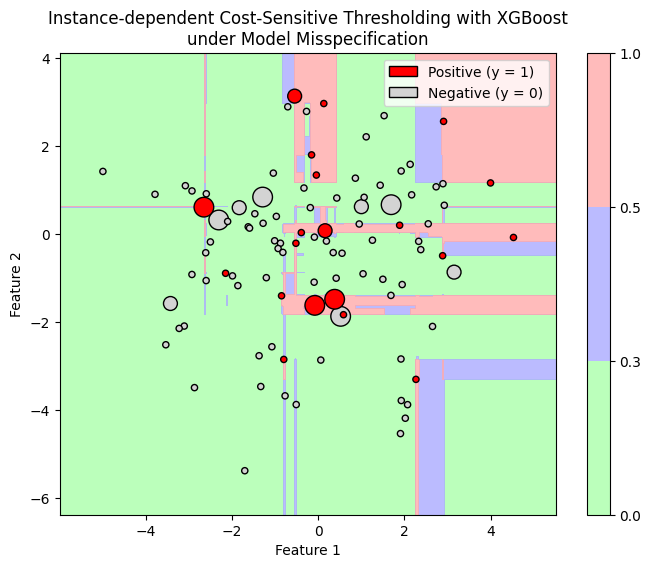

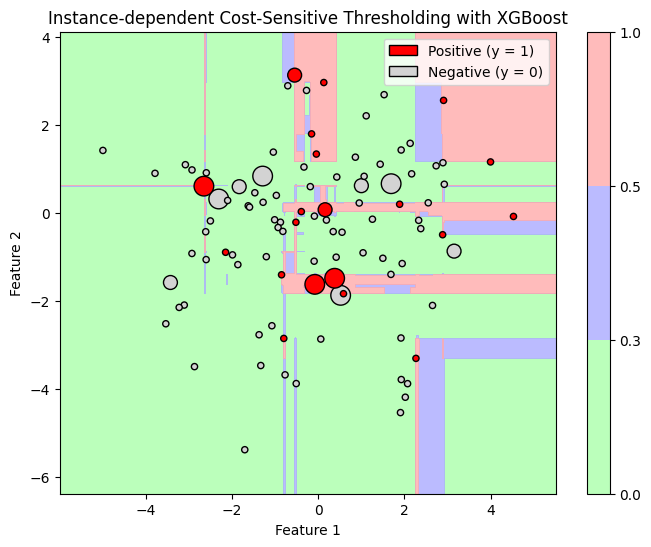

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import random
from sklearn.metrics import classification_report



# Helper functions
def generate_imbalanced_data(n, bias, scale, imbalance_ratio=0.3):
    """Generate synthetic imbalanced data with two features and a linear boundary."""
    n_class1 = int(n * imbalance_ratio)
    n_class2 = n - n_class1
    X1 = np.random.normal(loc=-bias, scale=scale, size=(n_class1, 2))
    X2 = np.random.normal(loc=bias, scale=scale, size=(n_class2, 2))
    X = np.vstack((X1, X2))
    y = np.array([0] * n_class1 + [1] * n_class2)
    return X, y

def assign_instance_weights(X, y, factor=10):
    """Assign small, medium, or large weights to a random subset of instances."""
    weights = np.ones(len(y))
    for i in range(int(len(y) * 0.2)):
        idx = random.randint(0, len(y) - 1)
        weight_type = random.choice(['small', 'medium', 'large'])
        if weight_type == 'small':
            weights[idx] = factor / 2 if y[idx] == 1 else 1
        elif weight_type == 'medium':
            weights[idx] = factor if y[idx] == 1 else factor / 2
        else:
            weights[idx] = factor * 2 if y[idx] == 1 else factor
    return weights


def plot_decision_boundary(model, X, y, title, thresholds, weights=None):
    """Plot decision boundary and data points."""
    cmap_light = ListedColormap(['#AAFFAA','#AAAAFF','#FFAAAA'])
    cmap_bold = ListedColormap(['#D3D3D3','#FF0000'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    sorted_thresholds = sorted(thresholds)
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(xx, yy, Z, levels=[0] + sorted_thresholds + [1], cmap=cmap_light, alpha=0.8)
    plt.colorbar(contour)
    if weights is not None:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolors='k', s=20 * weights)
    else:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolors='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    legend_elements = [Patch(facecolor='#FF0000', edgecolor='k', label='Positive (y = 1)'),
                       Patch(facecolor='#D3D3D3', edgecolor='k', label='Negative (y = 0)')]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()


# Data Generation
X_imb_well, y_imb_well = generate_imbalanced_data(100, bias=1.8, scale=1.5, imbalance_ratio=0.8)
X_imb_poor, y_imb_poor = generate_imbalanced_data(100, bias=0.5, scale=1.9, imbalance_ratio=0.8)

# Instance weights
weights_instance_well_spec = assign_instance_weights(X_imb_well, y_imb_well)
weights_instance_poor_spec = assign_instance_weights(X_imb_poor, y_imb_poor)

# Define thresholds for cost-sensitive thresholding
thresholds = [0.3, 0.5]  # Example of thresholds for cost-sensitive thresholding

# Defining class-dependent cost-sensitive weights
weights_class_well = np.where(y_imb_well == 1, 10, 1)  # More weight to the minority class
weights_class_poor = np.where(y_imb_poor == 1, 10, 1)  # More weight to the minority class

# Logistic Regression Models: Class-dependent Training
model_well_spec_lr = LogisticRegression()
model_poor_spec_lr = LogisticRegression()
# Fit models without weights for statistical training
model_well_spec_lr.fit(X_imb_well, y_imb_well)
model_poor_spec_lr.fit(X_imb_poor, y_imb_poor)
# Fit models with weights for cost-sensitive training
model_cost_well_spec_lr = LogisticRegression()
model_cost_poor_spec_lr = LogisticRegression()
model_cost_well_spec_lr.fit(X_imb_well, y_imb_well, sample_weight=weights_class_well)
model_cost_poor_spec_lr.fit(X_imb_poor, y_imb_poor, sample_weight=weights_class_poor)
# Fit models with weights for instance-dependent training
model_instance_well_spec_lr = LogisticRegression()
model_instance_poor_spec_lr = LogisticRegression()
model_instance_well_spec_lr.fit(X_imb_well, y_imb_well, sample_weight=weights_instance_well_spec)
model_instance_poor_spec_lr.fit(X_imb_poor, y_imb_poor, sample_weight=weights_instance_poor_spec)



# XGBoost Models: Class-dependent Training
model_well_spec_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_poor_spec_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# Fit models without weights for statistical training
model_well_spec_xgb.fit(X_imb_well, y_imb_well)
model_poor_spec_xgb.fit(X_imb_poor, y_imb_poor)
# Fit models with weights for cost-sensitive training
model_cost_well_spec_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_cost_poor_spec_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_cost_well_spec_xgb.fit(X_imb_well, y_imb_well, sample_weight=weights_class_well)
model_cost_poor_spec_xgb.fit(X_imb_poor, y_imb_poor, sample_weight=weights_class_poor)
# Fit models with weights for instance-dependent training
model_instance_well_spec_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_instance_poor_spec_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_instance_well_spec_xgb.fit(X_imb_well, y_imb_well, sample_weight=weights_instance_well_spec)
model_instance_poor_spec_xgb.fit(X_imb_poor, y_imb_poor, sample_weight=weights_instance_poor_spec)


# Generate grid for plotting
x_min, x_max = X_imb_well[:, 0].min() - 1, X_imb_well[:, 0].max() + 1
y_min, y_max = X_imb_well[:, 1].min() - 1, X_imb_well[:, 1].max() + 1
h = 0.02  # grid step size
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Generate grid predictions for both models
Z_normal = model_well_spec_lr.predict(np.c_[xx.ravel(), yy.ravel()])
Z_weighted = model_cost_well_spec_lr.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape for contourf plotting
Z_normal = Z_normal.reshape(xx.shape)
Z_weighted = Z_weighted.reshape(xx.shape)

# Visualization of all scenarios
# Class-dependent Logistic Regression
plot_decision_boundary(model_well_spec_lr, X_imb_well, y_imb_well, 'Class-dependent Statistical Training with Logistic Regression\nunder Model Specification', [0.5])
plot_decision_boundary(model_well_spec_lr, X_imb_well, y_imb_well, 'Class-dependent Statistical Training with Logistic Regression', [0.5])
plot_decision_boundary(model_poor_spec_lr, X_imb_poor, y_imb_poor, 'Class-dependent Statistical Training with Logistic Regression\nunder Model Misspecification', [0.5])
plot_decision_boundary(model_poor_spec_lr, X_imb_poor, y_imb_poor, 'Class-dependent Statistical Training with Logistic Regression', [0.5])
plot_decision_boundary(model_cost_well_spec_lr, X_imb_well, y_imb_well, 'Class-dependent Cost-Sensitive Training with Logistic Regression\nunder Model Specification', [0.5])
plot_decision_boundary(model_cost_well_spec_lr, X_imb_well, y_imb_well, 'Class-dependent Cost-Sensitive Training with Logistic Regression', [0.5])
plot_decision_boundary(model_cost_poor_spec_lr, X_imb_poor, y_imb_poor, 'Class-dependent Cost-Sensitive Training with Logistic Regression\nunder Model Misspecification', [0.5])
plot_decision_boundary(model_cost_poor_spec_lr, X_imb_poor, y_imb_poor, 'Class-dependent Cost-Sensitive Training with Logistic Regression', [0.5])
plot_decision_boundary(model_well_spec_lr, X_imb_well, y_imb_well, 'Class-dependent Cost-Sensitive Thresholding with Logistic Regression\nunder Model Specification', thresholds)
plot_decision_boundary(model_well_spec_lr, X_imb_well, y_imb_well, 'Class-dependent Cost-Sensitive Thresholding with Logistic Regression', thresholds)
plot_decision_boundary(model_poor_spec_lr, X_imb_poor, y_imb_poor, 'Class-dependent Cost-Sensitive Thresholding with Logistic Regression\nunder Model Misspecification', thresholds)
plot_decision_boundary(model_poor_spec_lr, X_imb_poor, y_imb_poor, 'Class-dependent Cost-Sensitive Thresholding with Logistic Regression', thresholds)

# Class-dependent XGBoost
plot_decision_boundary(model_well_spec_xgb, X_imb_well, y_imb_well, 'Class-dependent Training with XGBoost\nunder Model Specification', [0.5])
plot_decision_boundary(model_well_spec_xgb, X_imb_well, y_imb_well, 'Class-dependent Training with XGBoost', [0.5])
plot_decision_boundary(model_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Class-dependent Training with XGBoost\nunder Model Misspecification', [0.5])
plot_decision_boundary(model_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Class-dependent Training with XGBoost', [0.5])
plot_decision_boundary(model_cost_well_spec_xgb, X_imb_well, y_imb_well, 'Class-dependent Cost-Sensitive Training with XGBoost\nunder Model Specification', [0.5])
plot_decision_boundary(model_cost_well_spec_xgb, X_imb_well, y_imb_well, 'Class-dependent Cost-Sensitive Training with XGBoost', [0.5])
plot_decision_boundary(model_cost_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Class-dependent Cost-Sensitive Training with XGBoost\nunder Model Misspecification', [0.5])
plot_decision_boundary(model_cost_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Class-dependent Cost-Sensitive Training with XGBoost', [0.5])
plot_decision_boundary(model_well_spec_xgb, X_imb_well, y_imb_well, 'Class-dependent Cost-Sensitive Thresholding with XGBoost\nunder Model Specification', thresholds)
plot_decision_boundary(model_well_spec_xgb, X_imb_well, y_imb_well, 'Class-dependent Cost-Sensitive Thresholding with XGBoost', thresholds)
plot_decision_boundary(model_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Class-dependent Cost-Sensitive Thresholding with XGBoost\nunder Model Misspecification', thresholds)
plot_decision_boundary(model_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Class-dependent Cost-Sensitive Thresholding with XGBoost', thresholds)

# Instance-dependent Logistic Regression
plot_decision_boundary(model_instance_well_spec_lr, X_imb_well, y_imb_well, 'Instance-dependent Statistical Training with Logistic Regression\nunder Model Specification', [0.5], weights_instance_well_spec)
plot_decision_boundary(model_instance_well_spec_lr, X_imb_well, y_imb_well, 'Instance-dependent Statistical Training with Logistic Regression', [0.5], weights_instance_well_spec)
plot_decision_boundary(model_instance_poor_spec_lr, X_imb_poor, y_imb_poor, 'Instance-dependent Statistical Training with Logistic Regression\nunder Model Misspecification', [0.5], weights_instance_poor_spec)
plot_decision_boundary(model_instance_poor_spec_lr, X_imb_poor, y_imb_poor, 'Instance-dependent Statistical Training with Logistic Regression', [0.5], weights_instance_poor_spec)
plot_decision_boundary(model_cost_well_spec_lr, X_imb_well, y_imb_well, 'Instance-dependent Cost-Sensitive Training with Logistic Regression\nunder Model Specification', [0.5], weights_instance_well_spec)
plot_decision_boundary(model_cost_well_spec_lr, X_imb_well, y_imb_well, 'Instance-dependent Cost-Sensitive Training with Logistic Regression', [0.5], weights_instance_well_spec)
plot_decision_boundary(model_cost_poor_spec_lr, X_imb_poor, y_imb_poor, 'Instance-dependent Cost-Sensitive Training with Logistic Regression\nunder Model Misspecification', [0.5], weights_instance_poor_spec)
plot_decision_boundary(model_cost_poor_spec_lr, X_imb_poor, y_imb_poor, 'Instance-dependent Cost-Sensitive Training with Logistic Regression', [0.5], weights_instance_poor_spec)
plot_decision_boundary(model_instance_well_spec_lr, X_imb_well, y_imb_well, 'Instance-dependent Cost-Sensitive Thresholding with Logistic Regression\nunder Model Specification', thresholds, weights_instance_well_spec)
plot_decision_boundary(model_instance_well_spec_lr, X_imb_well, y_imb_well, 'Instance-dependent Cost-Sensitive Thresholding with Logistic Regression', thresholds, weights_instance_well_spec)
plot_decision_boundary(model_instance_poor_spec_lr, X_imb_poor, y_imb_poor, 'Instance-dependent Cost-Sensitive Thresholding with Logistic Regression\nunder Model Misspecification', thresholds, weights_instance_poor_spec)
plot_decision_boundary(model_instance_poor_spec_lr, X_imb_poor, y_imb_poor, 'Instance-dependent Cost-Sensitive Thresholding with Logistic Regression', thresholds, weights_instance_poor_spec)

# Instance-dependent XGBoost
plot_decision_boundary(model_instance_well_spec_xgb, X_imb_well, y_imb_well, 'Instance-dependent Training with XGBoost\nunder Model Specification', [0.5], weights_instance_well_spec)
plot_decision_boundary(model_instance_well_spec_xgb, X_imb_well, y_imb_well, 'Instance-dependent Training with XGBoost', [0.5], weights_instance_well_spec)
plot_decision_boundary(model_instance_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Instance-dependent Training with XGBoost\nunder Model Misspecification', [0.5], weights_instance_poor_spec)
plot_decision_boundary(model_instance_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Instance-dependent Training with XGBoost', [0.5], weights_instance_poor_spec)
plot_decision_boundary(model_cost_well_spec_xgb, X_imb_well, y_imb_well, 'Instance-dependent Cost-Sensitive Training with XGBoost\nunder Model Specification', [0.5], weights_instance_well_spec)
plot_decision_boundary(model_cost_well_spec_xgb, X_imb_well, y_imb_well, 'Instance-dependent Cost-Sensitive Training with XGBoost', [0.5], weights_instance_well_spec)
plot_decision_boundary(model_cost_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Instance-dependent Cost-Sensitive Training with XGBoost\nunder Model Misspecification', [0.5], weights_instance_poor_spec)
plot_decision_boundary(model_cost_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Instance-dependent Cost-Sensitive Training with XGBoost', [0.5], weights_instance_poor_spec)
plot_decision_boundary(model_instance_well_spec_xgb, X_imb_well, y_imb_well, 'Instance-dependent Cost-Sensitive Thresholding with XGBoost\nunder Model Specification', thresholds, weights_instance_well_spec)
plot_decision_boundary(model_instance_well_spec_xgb, X_imb_well, y_imb_well, 'Instance-dependent Cost-Sensitive Thresholding with XGBoost', thresholds, weights_instance_well_spec)
plot_decision_boundary(model_instance_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Instance-dependent Cost-Sensitive Thresholding with XGBoost\nunder Model Misspecification', thresholds, weights_instance_poor_spec)
plot_decision_boundary(model_instance_poor_spec_xgb, X_imb_poor, y_imb_poor, 'Instance-dependent Cost-Sensitive Thresholding with XGBoost', thresholds, weights_instance_poor_spec)
